In [786]:
!pip install xgboost
!pip install lightgbm

In [787]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import random
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import itertools

In [811]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
seed_everything(42)

In [812]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

## 데이터 피처 타입 확인
feature select 후 object 타입의 feature의 encoding 필요 (Gender, Age)

In [813]:
train.dtypes.value_counts()

float64    7
object     3
int64      1
dtype: int64

## 결측값 존재 확인
결측값이 존재하지 않아 따로 처리 불필요

In [814]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        7500 non-null   object 
 1   Exercise_Duration         7500 non-null   float64
 2   Body_Temperature(F)       7500 non-null   float64
 3   BPM                       7500 non-null   float64
 4   Height(Feet)              7500 non-null   float64
 5   Height(Remainder_Inches)  7500 non-null   float64
 6   Weight(lb)                7500 non-null   float64
 7   Weight_Status             7500 non-null   object 
 8   Gender                    7500 non-null   object 
 9   Age                       7500 non-null   int64  
 10  Calories_Burned           7500 non-null   float64
dtypes: float64(7), int64(1), object(3)
memory usage: 644.7+ KB


In [815]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        7500 non-null   object 
 1   Exercise_Duration         7500 non-null   float64
 2   Body_Temperature(F)       7500 non-null   float64
 3   BPM                       7500 non-null   float64
 4   Height(Feet)              7500 non-null   float64
 5   Height(Remainder_Inches)  7500 non-null   float64
 6   Weight(lb)                7500 non-null   float64
 7   Weight_Status             7500 non-null   object 
 8   Gender                    7500 non-null   object 
 9   Age                       7500 non-null   int64  
dtypes: float64(6), int64(1), object(3)
memory usage: 586.1+ KB


## 기초 통계량 확인
숫자의 값이 매우 큰 feature는 없어 log 변환은 굳이 진행할 필요 없어보임

features : exrecise_duration, body_temperatrue, bpm, height(feet), height(remainder_inches) weight, age, gender, weight, status
  
target : calories_burned

In [816]:
train.describe()

,Exercise_Duration,Body_Temperature(F),BPM,Height(Feet),Height(Remainder_Inches),Weight(lb),Age,Calories_Burned
count,7500.0000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000
mean,15.5012,104.033573,95.498133,5.248800,5.717600,165.361187,42.636000,89.373467
std,8.3553,1.412845,9.587331,0.556663,3.497315,33.308136,16.883188,62.817086
min,1.0000,98.800000,69.000000,4.000000,0.000000,79.400000,20.000000,1.000000
25%,8.0000,103.300000,88.000000,5.000000,3.000000,138.900000,28.000000,35.000000
50%,15.0000,104.400000,95.000000,5.000000,6.000000,163.100000,39.000000,77.000000
75%,23.0000,105.100000,103.000000,6.000000,9.000000,191.800000,56.000000,138.000000
max,30.0000,106.700000,128.000000,7.000000,12.000000,291.000000,79.000000,300.000000


## label encoding

In [817]:
ordinal_features = ['Weight_Status', 'Gender']

for feature in ordinal_features:
    le = LabelEncoder()
    le = le.fit(train[feature])
    train[feature] = le.transform(train[feature])

    # train데이터에서 존재하지 않았던 값이 test 데이터에 존재할 수도 있습니다.
    # 따라서 test 데이터를 바로 변형시키지 않고 고윳값을 확인후 test 데이터를 변환합니다.
    for label in np.unique(test[feature]):
        if label not in le.classes_:
            le.classes_ = np.append(le.classes_, label)
    test[feature] = le.transform(test[feature])

In [818]:
features = test.columns[1:]
X_test = test[features]


## 데이터의 분포 파악
log scale 필요 : Age, Calories_Bured

<AxesSubplot:xlabel='Age', ylabel='Count'>

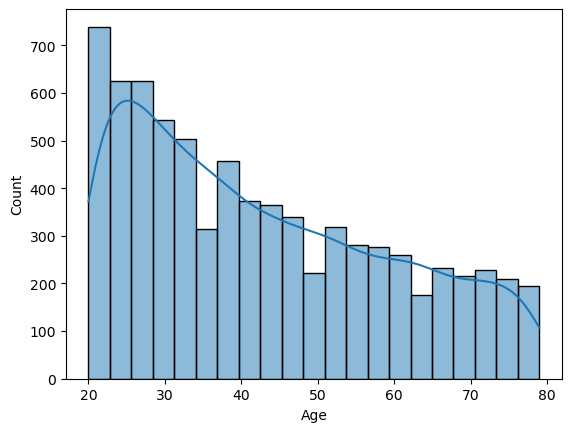

In [819]:
sns.histplot(train['Age'], kde=True)

<AxesSubplot:xlabel='Calories_Burned', ylabel='Count'>

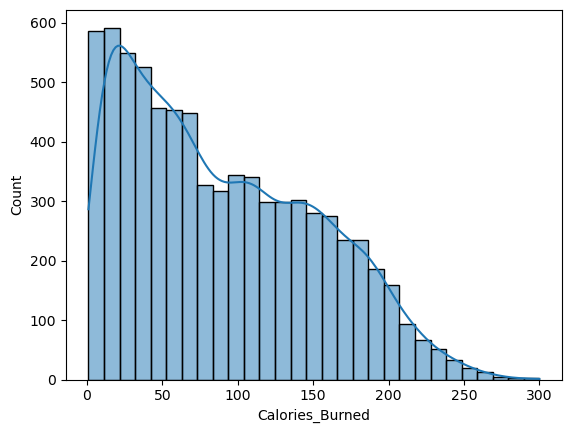

In [820]:
sns.histplot(train['Calories_Burned'], kde=True)

In [821]:
train['Calories_Burned']=np.log1p(train['Calories_Burned'])
train['Age']=np.log1p(train['Age'])

In [822]:
X_test['Age']=np.log1p(X_test['Age'])

## 타겟 변수 분리

In [823]:
features = train.columns[1:-1]
X = train[features]
y = train[['Calories_Burned']]

## 훈련, 검증 데이터 셋 분리

In [824]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=56)

## scaler

In [825]:
scalerX = StandardScaler()
scalerY = StandardScaler()
scalerX.fit(X_train)
scalerY.fit(y_train)

StandardScaler()

## 다항 특성 변환

In [826]:
poly = PolynomialFeatures()
X_train_poly = pd.DataFrame(poly.fit_transform(scalerX.fit_transform(X_train)))
X_val_poly = pd.DataFrame(poly.fit_transform(scalerX.fit_transform(X_val)))

## Model Selection
ridge, lasso, xgb, lgm 4개 모델 사용

In [804]:
## Ridge
ridge_reg = Ridge(random_state=56)
params_Ridge = {'alpha': [1,0.1,0.01,0.001,0.0001,0] , "fit_intercept": [True, False], "solver": ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}
Ridge_GS = GridSearchCV(ridge_reg, param_grid=params_Ridge,refit=True, n_jobs=-1, return_train_score=True, verbose=1, cv=5)
Ridge_GS.fit(X_train_poly, scalerY.fit_transform(y_train))

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=5, estimator=Ridge(random_state=56), n_jobs=-1,
             param_grid={'alpha': [1, 0.1, 0.01, 0.001, 0.0001, 0],
                         'fit_intercept': [True, False],
                         'solver': ['svd', 'cholesky', 'lsqr', 'sparse_cg',
                                    'sag', 'saga']},
             return_train_score=True, verbose=1)

In [ ]:
# Lasso
lasso_reg = Lasso(random_state=56)
lasso_parameters = {
 'alpha': np.arange(0.00, 1.0, 0.01)
}
Lasso_GS = GridSearchCV(lasso_reg, param_grid=lasso_parameters,refit=True, n_jobs=-1, return_train_score=True, verbose=1, cv=5)
Lasso_GS.fit(X_train_poly, scalerY.fit_transform(y_train))

In [832]:
# XGB

xgb= XGBRegressor(random_state=56, tree_method='gpu_hist', gpu_id=0)
xgb_param_grid={
    'n_estimators' : [100,200,300,400,500],
    'learning_rate' : [0.01,0.05,0.1,0.15],
    'max_depth' : [3,5,7,10,15],
    'gamma' : [0,1,2,3],
    'colsample_bytree' : [0.8,0.9],
    
}
XGB_GS = GridSearchCV(xgb, param_grid=xgb_param_grid,refit=True, n_jobs=-1, return_train_score=True, verbose=1, cv=5)
XGB_GS.fit(X_train_poly, scalerY.fit_transform(y_train))

Fitting 5 folds for each of 800 candidates, totalling 4000 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=0,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=56, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 0.9], 'gamma': [0, 1, 2, 3],
                         'learning_rate': [0.01, 0.05, 0.1, 0.15],
                         'max_depth': [3, 5, 7, 10, 15],
                         'n_estimators': [100, 200, 300, 400, 500]},
             return_train_score=True, verbose=1)

In [ ]:
# lgbm
lgbm = LGBMRegressor()
params = {
    'num_leaves': [7, 14, 21, 28, 31, 50],
    'learning_rate': [0.1, 0.03, 0.003],
    'max_depth': [-1, 3, 5],
    'n_estimators': [50, 100, 200, 500],
}

LGBM_GS = GridSearchCV(lgbm, param_grid=params,refit=True, n_jobs=-1, return_train_score=True, verbose=1, cv=5)
LGBM_GS.fit(X_train_poly, scalerY.fit_transform(y_train))

In [ ]:
ridge_pred = Ridge_GS.predict(poly.fit_transform(X_test)).reshape(-1, 1)
lasso_pred = Lasso_GS.predict(poly.fit_transform(X_test)).reshape(-1, 1)
xgb_pred = XGB_GS.predict(poly.fit_transform(X_test)).reshape(-1, 1)
lgbm_pred = LGBM_GS.predict(poly.fit_transform(X_test)).reshape(-1, 1)

In [ ]:
for i in [ridge_pred, lasso_pred, xgb_pred, lgbm_pred]:
    print(mean_squared_error(np.expm1(i), prediction))

In [ ]:
mmin_error = 1000000

In [ ]:
num = 0
for i in range(0, 101, 1):
    for j in range(0, 101, 1):
        for p in range(0, 101, 1):
            for q in range(0, 101, 1):
                if i+j+q+p == 100:
                    prediction = np.expm1((i/100)*ridge_pred + (j/100)*lasso_pred + (q/100)*xgb_pred + (p/100)*lgbm_pred)
                    error = mean_squared_error(np.expm1(y_val), prediction)
                    if error < mmin_error:
                        mmin_error = error
                        ri = i
                        la = j
                        xg = q
                        lg = p
                num +=1        
                if num %1000000 == 0:
                    print(num, '===', num/100**4, 'mmin_error = ', mmin_error)

In [833]:
pred = XGB_GS.predict(X_val_poly)

In [834]:
pred

array([ 0.24088678, -0.0226793 ,  0.8913783 , ...,  1.081361  ,
        0.88288176,  0.26692688], dtype=float32)

In [836]:
scalerY.inverse_transform((pred.reshape(-1,1)))

array([[4.3926826],
       [4.140035 ],
       [5.0162253],
       ...,
       [5.1983376],
       [5.008081 ],
       [4.417644 ]], dtype=float32)

In [838]:
np.expm1(scalerY.inverse_transform((pred.reshape(-1, 1))))

array([[ 79.85703],
       [ 61.80503],
       [149.84085],
       ...,
       [179.97113],
       [148.61734],
       [ 81.90074]], dtype=float32)

In [839]:
np.expm1(y_val)

,Calories_Burned
6832,75.0
4305,62.0
2302,146.0
6799,165.0
4259,22.0
...,...
4442,49.0
933,96.0
6476,185.0
6975,145.0


In [746]:
mean_squared_error(scalerY.inverse_transform(pred), y_val)

15.426797640183091

In [652]:
pred.reshape(-1,1)

array([[ 0.18954646],
       [-0.0311805 ],
       [ 0.8184945 ],
       ...,
       [ 0.84883435],
       [ 0.87910656],
       [ 0.27539211]])

In [675]:
scalerY.inverse_transform(pred.reshape(-1,1))

array([[ 4911.47408473],
       [ 4042.60987622],
       [ 9439.83172787],
       ...,
       [11722.48580664],
       [ 9269.79509711],
       [ 5347.81279115]])

In [612]:
prediction = np.expm1(0.08*ridge_pred + 0.00*lasso_pred + 0.48*xgb_pred + 0.44*lgbm_pred)

In [679]:
mean_squared_error(y_val, pred)

9.20415634063125

In [614]:
submission['Calories_Burned'] = prediction

In [615]:
submission.to_csv('sub_test.csv')